In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import regression_report, sklearn_to_df

# Sklearn Skeleton

In [2]:
open_ml_dataset_names = ['titanic', 'credit-g', 'liver-disorders', 'cholesterol', 'spambase', 'bodyfat']

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
from sklearn.datasets import fetch_openml
OPEN_ML_DS_NAME = 'spambase' #Add name of toy data set here
df = sklearn_to_df(fetch_openml(OPEN_ML_DS_NAME, version=1, as_frame=True, return_X_y=False))

In [5]:
TARGET_NAME = 'target'
FEATURE_NAMES = list(df.columns)
FEATURE_NAMES.remove(TARGET_NAME)
numeric_feature_names = list(df[FEATURE_NAMES].select_dtypes('number').columns)
categoric_feature_names = list( set(df[FEATURE_NAMES].columns) - set(numeric_feature_names))
N_levels = 15
is_classification = len(df[TARGET_NAME].unique()) <= N_levels
is_classification
print(f'{"Regression Problem" if not is_classification else "Classification Problem"}, \
      Target Name: {TARGET_NAME}, Data Set: {OPEN_ML_DS_NAME}')

Classification Problem,       Target Name: target, Data Set: spambase


In [6]:
#Create pipeline
from sklearn import set_config
set_config(display="diagram")
imputer = SimpleImputer()
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy = 'mean')),
                                ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                                    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))]
                                  )
preprocessor = ColumnTransformer(transformers = [('numeric', numeric_transformer, numeric_feature_names),
                                                 ('categoric', categorical_transformer, categoric_feature_names)]
                                )

estimator = LogisticRegression() if is_classification else LinearRegression()

pipe = Pipeline(steps = [('preprocessing', preprocessor), ('estimator' , estimator)])
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['word_freq_make',
                                                   'word_freq_address',
                                                   'word_freq_all',
                                                   'word_freq_3d',
                                                   'word_freq_our',
                                                   'word_freq_over',
                                                   'word_freq_remove',
                                                   'word_freq_internet',
                                                   'word_freq_order',
                                                   'word_freq_mail',
                                                   'word_freq_receive',
                                                   'wo...
                                                   'word_freq_your',
                                                   'word_freq_font',
                                                   'word_freq_000',
                                                   'word_freq_money',
                                                   'word_freq_hp',
                                                   'word_freq_hpl',
                                                   'word_freq_george',
                                                   'word_freq_650',
                                                   'word_freq_lab',
                                                   'word_freq_labs', ...]),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('estimator', LogisticRegression())])

In [7]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]
#Add custom splitting scheme here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
from sklearn.metrics import classification_report, plot_roc_curve
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
print(classification_report(y_test, y_hat)) if is_classification else print (regression_report(y_test, y_hat))


              precision    recall  f1-score   support

           0       0.91      0.94      0.93       822
           1       0.91      0.86      0.89       559

    accuracy                           0.91      1381
   macro avg       0.91      0.90      0.91      1381
weighted avg       0.91      0.91      0.91      1381



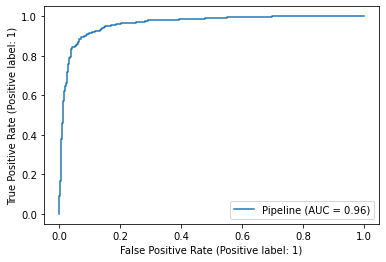

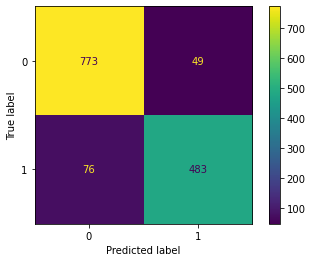

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
if is_classification and len(y_test.unique()) <= 2:
    RocCurveDisplay.from_estimator(pipe, X_test, y_test)
if is_classification:
    cm = confusion_matrix(y_test, y_hat, labels = pipe.named_steps['estimator'].classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['estimator'].classes_).plot()

# Cross Validate

In [10]:
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro', 'accuracy'] if is_classification else ['r2', 'explained_variance',
                                                                         'neg_mean_absolute_error',
                                                                        'neg_mean_absolute_percentage_error']
from sklearn.model_selection import cross_validate
scores = cross_validate(pipe, X, y, scoring=scoring, cv = 10)

In [11]:
score_df = pd.DataFrame(scores)
score_df = pd.concat([score_df, score_df.agg(['mean'])]) 
pd.DataFrame(score_df.loc['mean'])

,mean
fit_time,0.131094
score_time,0.019356
test_precision_macro,0.916083
test_recall_macro,0.910850
test_accuracy,0.917189


# Plotting Feature Importances or Coefficients

In [12]:
if categoric_feature_names != []:
    cat_feature_names_out = pipe.named_steps['preprocessing'].named_transformers_['categoric'].named_steps['encoder'].get_feature_names_out(categoric_feature_names)
else:
    cat_feature_names_out = categoric_feature_names 
feature_names_out = list(set(cat_feature_names_out) | set(numeric_feature_names))
if isinstance(pipe.named_steps['estimator'], LogisticRegression):
    importances = {name : value for name, value in zip(feature_names_out, pipe.named_steps['estimator'].coef_[0])}
if isinstance(pipe.named_steps['estimator'], LinearRegression):
    importances = {name : value for name, value in zip(feature_names_out, pipe.named_steps['estimator'].coef_)}

    
importances = importances if not isinstance(list(importances.values())[0], np.ndarray) else \
                {k : np.mean(v) for k,v in importances.items()}
importances = dict(sorted(importances.items(), key=lambda item: -item[1]))


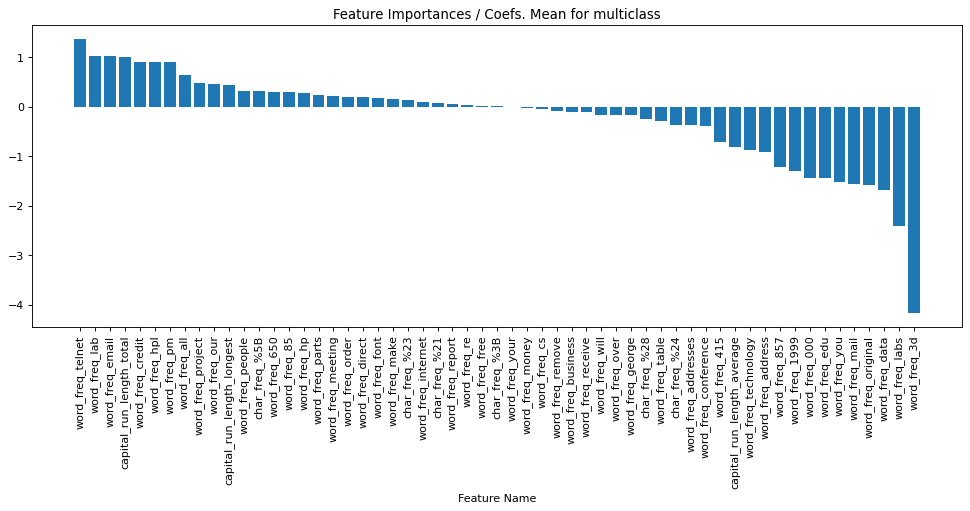

In [13]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(range(len(importances)), list(importances.values()), align='center')
plt.xticks(range(len(importances)), list(importances.keys()), rotation = 90)
plt.title('Feature Importances / Coefs. Mean for multiclass')
plt.xlabel('Feature Name')
plt.show()

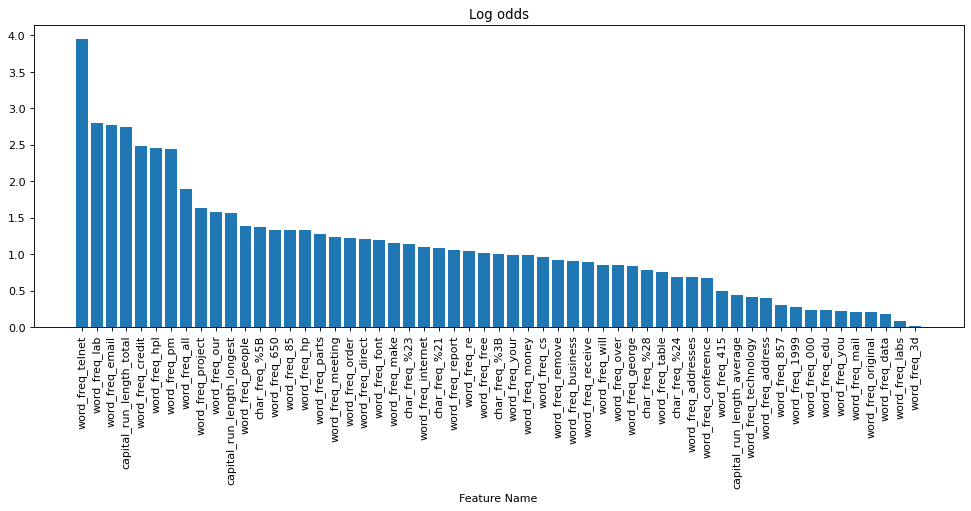

In [14]:
if is_classification:
    plt.figure(figsize=(15, 5), dpi=80)
    plt.bar(range(len(importances)), [np.exp(e) for e in importances.values()], align='center')
    plt.xticks(range(len(importances)), list(importances.keys()), rotation = 90)
    plt.title('Log odds')
    plt.xlabel('Feature Name')
    plt.show()

# Plotting Residuals

In [15]:
from statsmodels.graphics.gofplots import qqplot
if not is_classification:
    residuals = y_hat-y_test
    plt.hist(residuals, bins = 35)
    plt.show()
    plt.plot(np.abs(y_test - y_hat), 'o')
    plt.ylabel('||$\hat{y} - y}$||', fontsize = 10)

# Testing Different Estimators

In [19]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

params_grid_reg = [{'estimator':[LinearRegression()]},{'estimator': [Ridge()],},{'estimator': [ElasticNet()],},
                  {'estimator':[DummyRegressor()]},{'estimator':[SVR()]},{'estimator':[DecisionTreeRegressor()]},
                  {'estimator':[AdaBoostRegressor()]}]

params_grid_class = [{'estimator':[LogisticRegression()]},{'estimator':[DecisionTreeClassifier()]},
                     {'estimator':[AdaBoostClassifier()]}]

params_grid = params_grid_class if is_classification else params_grid_reg
class_metrics = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']
reg_metrics = ['r2', 'explained_variance', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe,
                    params_grid,
                    scoring = class_metrics if is_classification else reg_metrics,
                    refit = False,
                    cv=5,
                   verbose = True)

In [20]:
results = grid.fit(X_train,y_train)
class_metrics_names = ['param_estimator'] + [f'mean_test_{metric}' for metric in class_metrics]
reg_metrics_names = ['param_estimator'] + [f'mean_test_{metric}' for metric in reg_metrics]
cs = class_metrics_names if is_classification else reg_metrics_names
pd.DataFrame(grid.cv_results_)[cs]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,param_estimator,mean_test_precision_macro,mean_test_recall_macro,mean_test_accuracy,mean_test_f1_macro
0,LogisticRegression(),0.924989,0.917190,0.925155,0.920619
1,DecisionTreeClassifier(),0.904932,0.903826,0.909006,0.904212
2,AdaBoostClassifier(),0.943727,0.940398,0.945031,0.941970
